# Logistic Regression (Olive Oils dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# model mode (training'or 'predict')
model_mode      = 'predict'

# data filenames
data_filename   = '../../data/olive_oils/FTIR_olive_oils.csv'
sample_filename = '../generative_models/ppc_samples_olive_oils.csv'
trace_filename  = './traces/trace_olive_oils'
ppc_filename    = './ppc_samples_olive_oils_predicted.csv'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -3)

if model_mode == 'training':    
    data_obj.data.head(5)
else:
    sample_obj = Data(sample_filename, 'label', -1)

Greece: blue
Italy: red
Portugal: green
Spain: orange


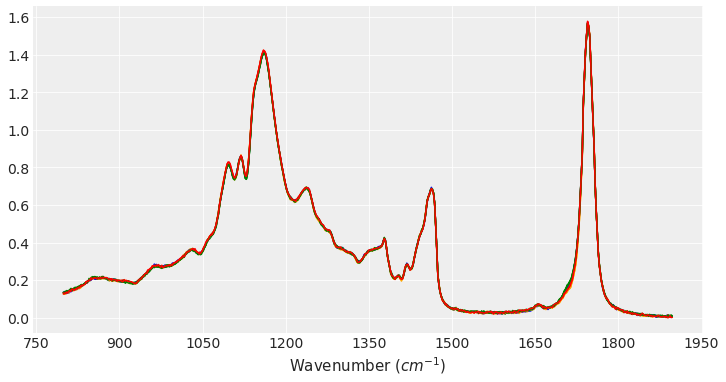

In [5]:
# plot dataframe
if model_mode == 'training':
    utl.plot_data(data_obj, 20)
else:
    utl.plot_data(sample_obj, 10)

In [6]:
# number of samples from each class
if model_mode == 'training':
    print(data_obj.data[data_obj.label_column].value_counts())
else:
    print(sample_obj.data[sample_obj.label_column].value_counts())

Italy       50
Portugal    50
Spain       50
Greece      50
Name: label, dtype: int64


In [7]:
# generate training and test sets
train_data, test_data = train_test_split(data_obj.data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [8]:
test_data.shape

(40, 573)

In [9]:
train_data.shape

(80, 573)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = softmax(\alpha+\beta X) \\
y \sim Categorical(\theta)
\end{equation}

In [10]:
# get Y labels and standardize the data
Y = pd.Categorical(train_data[data_obj.label_column]).codes
x_n = train_data.columns[:data_obj.non_data_columns]
x_s = train_data[x_n].values
x_s = utl.standardize(x_s)

In [12]:
import theano.tensor as tt

with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=data_obj.classes-1)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(len(x_n), data_obj.classes-1))
    alpha_f = tt.concatenate([[0], alpha])
    beta_f = tt.concatenate([np.zeros((len(x_n), 1)), beta], axis=1)
    
    mu = pm.Deterministic('mu', alpha_f + pm.math.dot(x_s, beta_f))
    
    theta = tt.nnet.softmax(mu)
                     
    y_pred = pm.Categorical('y_pred', p=theta, observed=Y)
                     
    if model_mode == 'training':
        trace_mlr = pm.sample(2000, init='adapt_diag', random_seed=42)
    else:
        # load traces from trained model
        trace_mlr = pm.backends.text.load(trace_filename)

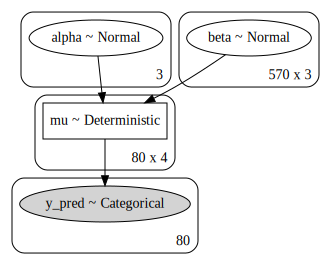

In [13]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [14]:
if model_mode == 'training':
    varnames = ['alpha', 'beta']
    coef = az.summary(trace_mlr, varnames)
    print(coef)

In [15]:
if model_mode == 'training':
    az.plot_energy(trace_mlr, figsize=(10, 6));

# Model predictions

In [19]:
if model_mode == 'training':
    # prediction score on training data
    utl.softmax_score(data_obj, train_data, trace_mlr)
    # todo: implement function for testset prediction
    # --> utl.softmax_score(data_obj, test_data, trace_mlr)
#else:
    # prediction score on sample data
    # todo: implement function for sample prediction
    # --> utl.softmax_score_ppc(sample_obj, 'xxxx')

## Save results

In [20]:
if model_mode == 'training':
    # save inference results
    pm.backends.text.dump(trace_filename, trace_mlr)
else:
    # save prediction results
    sample_obj.data.to_csv(ppc_filename, index=False)